In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from transformers import RobertaModel
import torch

# Initialize the model
model = RobertaModel.from_pretrained('roberta-base')

# Load the state_dict with strict=False
state_dict = torch.load('/content/drive/MyDrive/codebert.pth')
model.load_state_dict(state_dict, strict=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.att

In [3]:
# Adjust the keys if necessary
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace('roberta.', '')  # Remove 'roberta.' prefix if present
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['pooler.dense.weight', 'pooler.dense.bias'], unexpected_keys=['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias'])

In [4]:
from transformers import RobertaForSequenceClassification
import torch

# Load the model with the correct number of classes
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=7)

# Load the state_dict with strict=False
model.load_state_dict(torch.load('/content/drive/MyDrive/codebert.pth'), strict=False)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [6]:
import pandas as pd

In [7]:
df = pd.read_json("hf://datasets/codeparrot/codecomplex/data.jsonl", lines=True)

In [10]:
from sklearn.model_selection import train_test_split

# Extract features and labels
codes = df['src'].tolist()
labels = df['complexity'].tolist()  # Replace 'label' with the actual column name if different

# Split the data: 80% for training and 20% for testing
train_texts, test_texts, train_labels, test_labels = train_test_split(
    codes, labels, test_size=0.2, random_state=42
)


In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform both train and test labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)


In [13]:
train_labels_tensor = torch.tensor(train_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)


In [14]:
# Convert input ids and attention masks to torch tensors
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_mask = torch.tensor(train_encodings['attention_mask'])

test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])

# Create DataLoaders
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=16)


In [15]:
model.eval()  # Set the model to evaluation mode


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [16]:
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get the predicted class with the highest score
        preds = torch.argmax(logits, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [69]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8728
Precision: 0.8770
Recall: 0.8728
F1 Score: 0.8725


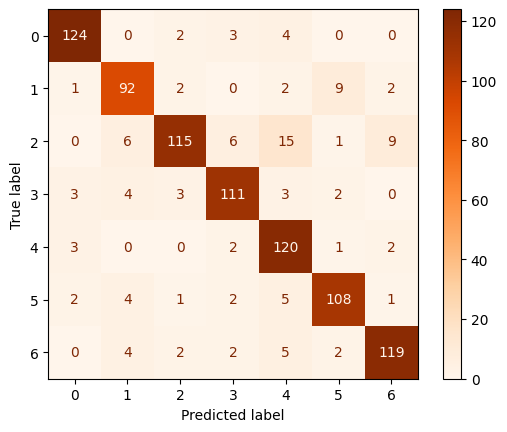

In [75]:
# Compute and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.show()

In [29]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Simulate prediction probabilities from the model
model.eval()  # Ensure the model is in evaluation mode

all_probs = []  # Initialize a list to store probabilities
all_labels = []  # To store true labels

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to probabilities
        probs = F.softmax(logits, dim=1)  # Apply softmax to get class probabilities

        # Store probabilities and true labels
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Binarize the true labels for multi-class ROC curve
n_classes = all_probs.shape[1]  # Number of classes
all_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Check shapes
print("Shape of all_probs:", all_probs.shape)
print("Shape of all_labels_binarized:", all_labels_binarized.shape)


Shape of all_probs: (904, 7)
Shape of all_labels_binarized: (904, 7)


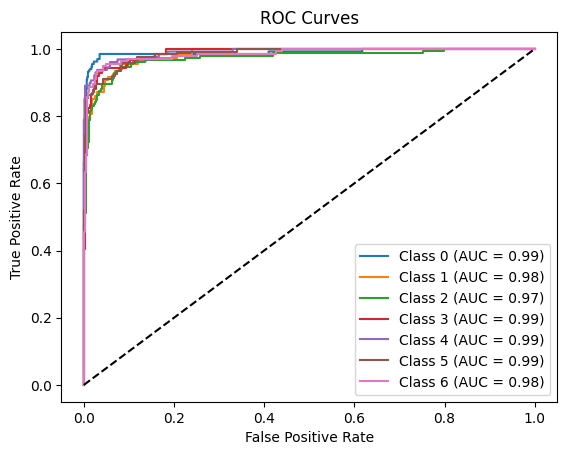

In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="best")
plt.show()


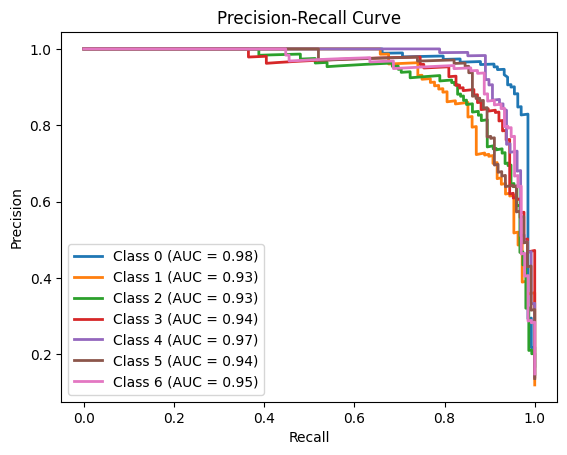

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc

# Assuming all_labels and all_probs are already defined and correctly formatted
# Binarize the true labels for multi-class Precision-Recall curve
n_classes = all_probs.shape[1]  # Number of classes
all_labels_binarized = label_binarize(all_labels, classes=range(n_classes))

# Initialize dictionaries to store Precision-Recall metrics
precision = dict()
recall = dict()
pr_auc = dict()

# Calculate Precision-Recall curve and AUC for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_binarized[:, i], all_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot Precision-Recall curves
plt.figure()

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f"Class {i} (AUC = {pr_auc[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


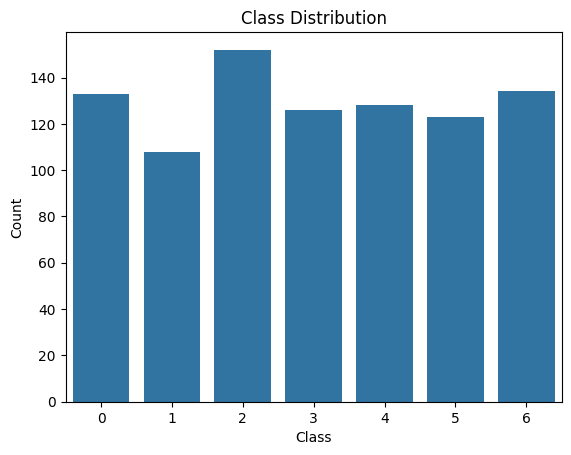

In [41]:
# Ensure all_labels is a 1D array of true labels
import seaborn as sns
import matplotlib.pyplot as plt

# Convert all_labels to a Pandas DataFrame for easy plotting
import pandas as pd
df_labels = pd.DataFrame({'Labels': all_labels})

# Plot class distribution
sns.countplot(x='Labels', data=df_labels)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [82]:
label_encoder = LabelEncoder()
label_encoder.fit(['constant', 'cubic', 'linear', 'logn', 'nlogn', 'np', 'quadratic'])

LabelEncoder()

In [84]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Tokenize new data
new_codes=["""import java.util.Scanner; public class maestro{ public static void main(String[] args){ Scanner sc = new Scanner(System.in); int N = sc.nextInt(); long mod = (long)Math.pow(10,9)+7; long[][] arr = new long[N][N]; arr[0][0]=1; for (int i=1;i<N;i++){ char c = sc.next().charAt(0); if (c=='f'){ for (int j=1;j<N;j++) arr[i][j] = arr[i - 1][j - 1]; } else { long sum=0; for (int j=N-1;j>=0;j--){ sum=(sum+arr[i-1][j])%mod; arr[i][j] = sum; } } } long ans=0; for (int i=0;i<N;i++) ans=(ans+arr[N-1][i])%mod; System.out.println(ans); } }"""]
new_inputs = tokenizer(new_codes, padding=True, truncation=True, return_tensors="pt")

actual_labels = [6]
# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(**new_inputs)
    _, predicted = torch.max(outputs.logits, 1)

predicted_labels = label_encoder.inverse_transform(predicted.cpu().numpy())
actual_labels = label_encoder.inverse_transform(actual_labels)
print(f"Predicted time complexity: {predicted_labels}")
print((f"Actual time complexity: {actual_labels}"))


Predicted time complexity: ['quadratic']
Actual time complexity: ['quadratic']
